## Prov-GigaPath Embedding Visualization

### Prepare HF Token

To begin, please request access to the model from our HuggingFace repository: https://huggingface.co/prov-gigapath/prov-gigapath.

Once approved, set the HF_TOKEN to access the model.

In [1]:
import os

# Please set your Hugging Face API token
# os.environ["HF_TOKEN"] = ""

assert "HF_TOKEN" in os.environ, "Please set the HF_TOKEN environment variable to your Hugging Face API token"

In [2]:
import timm

model = timm.create_model("hf_hub:prov-gigapath/prov-gigapath", pretrained=True)

/home/naotous/miniconda3/envs/run_gigapath/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from typing import List

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

def load_and_preprocess_image(image_path: str) -> Image.Image:
    with open(image_path, 'rb') as f:
        img = Image.open(f).convert('RGB')
    return img

pca = PCA(n_components=3)
scaler = MinMaxScaler(clip=True)

def process_images(images: List[Image.Image], background_threshold: float = 0.5, larger_pca_as_fg: bool = False) -> List[np.ndarray]:
    imgs_tensor = torch.stack([transform(img).to(device) for img in images])

    with torch.no_grad():
        intermediate_features = model.forward_intermediates(imgs_tensor, intermediates_only=True)
        features = intermediate_features[-1].permute(0, 2, 3, 1).reshape(-1, 1536).cpu()

    pca_features = scaler.fit_transform(pca.fit_transform(features))

    if larger_pca_as_fg:
        fg_indices = pca_features[:, 0] > background_threshold
    else:
        fg_indices = pca_features[:, 0] < background_threshold

    fg_features = pca.fit_transform(features[fg_indices])

    scaler.fit(fg_features)
    normalized_features = scaler.transform(fg_features)

    # Prepare the result
    result_img = np.zeros((imgs_tensor.size(0) * 196, 3))  # Assuming 14x14 patches
    result_img[fg_indices] = normalized_features

    imgs_tensor = imgs_tensor.cpu()

    transformed_imgs = []
    for i, img in enumerate(imgs_tensor):
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img_np = (img_np * 255).astype(np.uint8)
        transformed_imgs.append(img_np)

    results = [result_img.reshape(imgs_tensor.size(0), 14, 14, 3)[i] for i in range(len(images))]

    return results, transformed_imgs, pca_features

In [4]:
image_paths = [
    "../images/01581x_25327y.png",
    "../images/01581x_25583y.png",
]

In [5]:
images = [load_and_preprocess_image(path) for path in image_paths]
results, transformed_imgs, pca_features = process_images(images, larger_pca_as_fg=False)

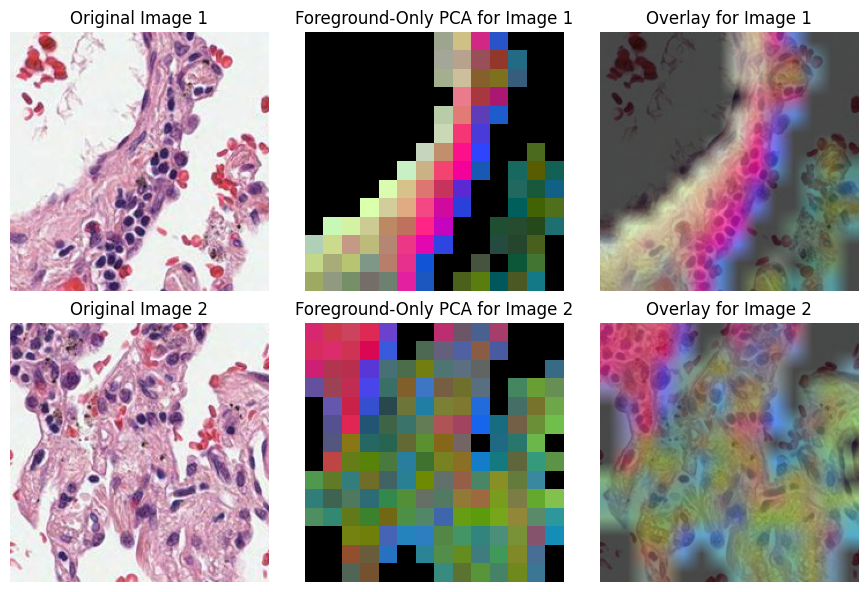

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_overlay_image(original, result, alpha=0.3):
    # Resize result to match the original image size
    result_resized = cv2.resize(result, (original.shape[1], original.shape[0]))
    overlay = (alpha * original + (1 - alpha) * result_resized * 255).astype(np.uint8)
    return overlay

num_images = len(transformed_imgs)

fig, axes = plt.subplots(num_images, 3, figsize=(9, 3 * num_images))

for i, (image, result) in enumerate(zip(transformed_imgs, results)):
    overlay = create_overlay_image(image, result)

    # Original image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis('off')

    # PCA result image
    axes[i, 1].imshow(result)
    axes[i, 1].set_title(f"Foreground-Only PCA for Image {i+1}")
    axes[i, 1].axis('off')

    # Overlay image
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title(f"Overlay for Image {i+1}")
    axes[i, 2].axis('off')

#fig.suptitle('PCA Visualizations', fontsize=20)

plt.tight_layout()
plt.show()

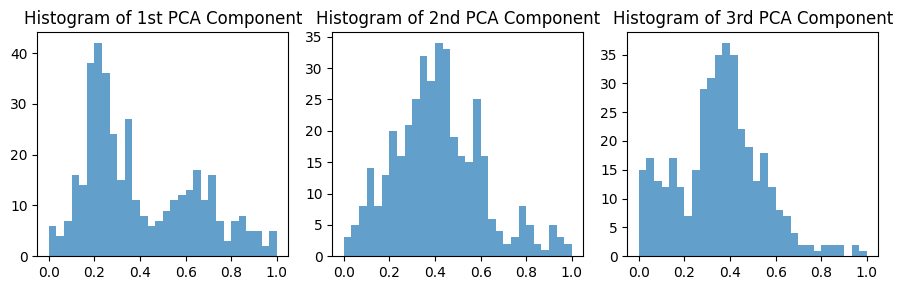

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.hist(pca_features[:, 0], bins=30, alpha=0.7)
plt.title('Histogram of 1st PCA Component')

plt.subplot(1, 3, 2)
plt.hist(pca_features[:, 1], bins=30, alpha=0.7)
plt.title('Histogram of 2nd PCA Component')

plt.subplot(1, 3, 3)
plt.hist(pca_features[:, 2], bins=30, alpha=0.7)
plt.title('Histogram of 3rd PCA Component')

plt.tight_layout()
plt.show()
plt.close()

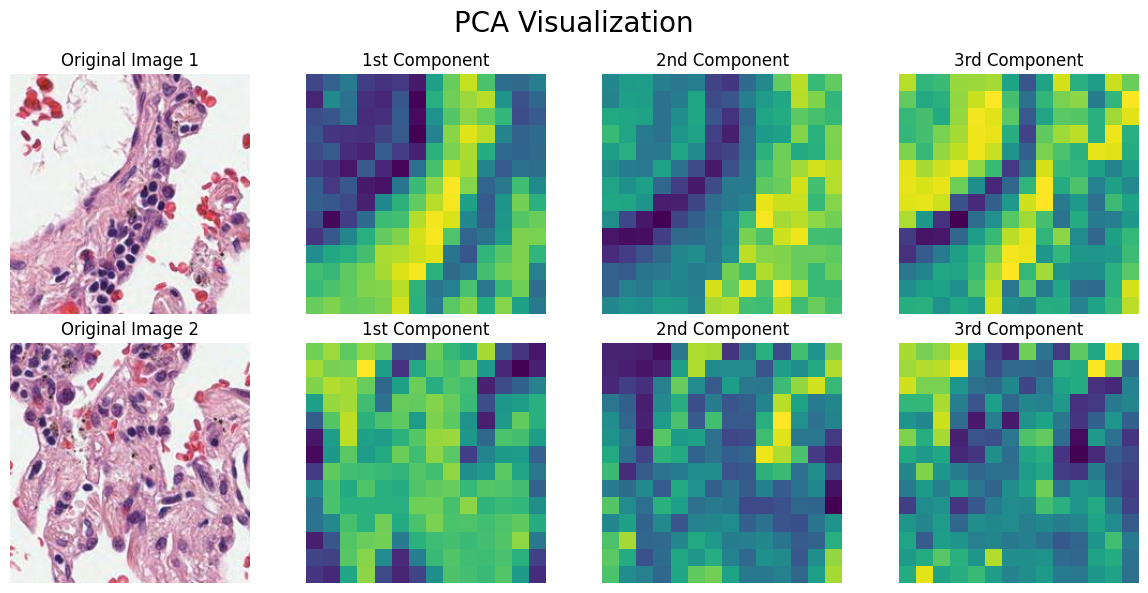

In [13]:
import matplotlib.pyplot as plt

patch_h, patch_w = 14, 14

fig, axes = plt.subplots(num_images, 4, figsize=(12, 3 * num_images))

for i in range(num_images):
    # Original image
    axes[i, 0].imshow(transformed_imgs[i])
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis('off')

    # First component
    component1 = pca_features[i * patch_h * patch_w : (i + 1) * patch_h * patch_w, 0].reshape(patch_h, patch_w)
    axes[i, 1].imshow(component1, cmap='viridis_r')
    axes[i, 1].set_title(f'1st Component')
    axes[i, 1].axis('off')

    # Second component
    component2 = pca_features[i * patch_h * patch_w : (i + 1) * patch_h * patch_w, 1].reshape(patch_h, patch_w)
    axes[i, 2].imshow(component2, cmap='viridis_r')
    axes[i, 2].set_title(f'2nd Component')
    axes[i, 2].axis('off')

    # Third component
    component3 = pca_features[i * patch_h * patch_w : (i + 1) * patch_h * patch_w, 2].reshape(patch_h, patch_w)
    axes[i, 3].imshow(component3, cmap='viridis_r')
    axes[i, 3].set_title(f'3rd Component')
    axes[i, 3].axis('off')

    # RGB visualization
    # rgb_image = np.stack((component3, component2, component1), axis=-1)
    # axes[i, 4].imshow(rgb_image)
    # axes[i, 4].set_title(f'RGB Visualization')
    # axes[i, 4].axis('off')

fig.suptitle('PCA Visualization', fontsize=20)
plt.tight_layout()
plt.show()

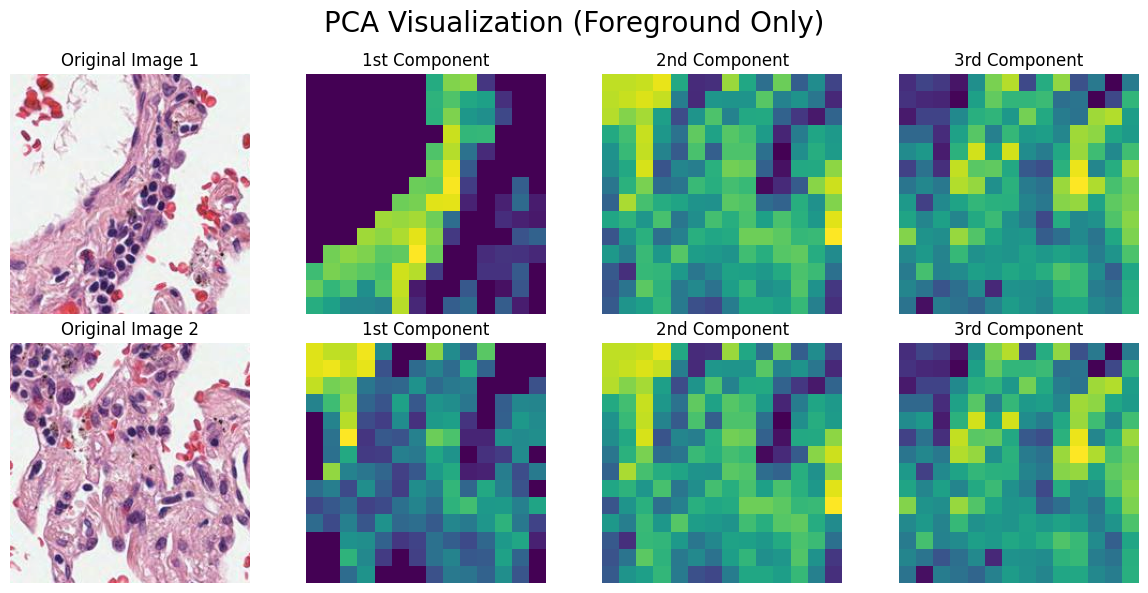

In [14]:
import matplotlib.pyplot as plt

patch_h, patch_w = 14, 14

fig, axes = plt.subplots(num_images, 4, figsize=(12, 3 * num_images))

for i in range(num_images):
    # Original image
    axes[i, 0].imshow(transformed_imgs[i])
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis('off')

    # First component
    component1 = results[i][:, :, 0]
    axes[i, 1].imshow(component1, cmap='viridis')
    axes[i, 1].set_title(f'1st Component')
    axes[i, 1].axis('off')

    # Second component
    component1 = results[i][:, :, 1]
    axes[i, 2].imshow(component2, cmap='viridis')
    axes[i, 2].set_title(f'2nd Component')
    axes[i, 2].axis('off')

    # Third component
    component1 = results[i][:, :, 2]
    axes[i, 3].imshow(component3, cmap='viridis')
    axes[i, 3].set_title(f'3rd Component')
    axes[i, 3].axis('off')

    # RGB visualization
    # rgb_image = np.stack((component3, component2, component1), axis=-1)
    # axes[i, 4].imshow(rgb_image)
    # axes[i, 4].set_title(f'RGB Visualization')
    # axes[i, 4].axis('off')

fig.suptitle('PCA Visualization (Foreground Only)', fontsize=20)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Define a custom colormap
viridis_with_black = plt.cm.viridis(np.linspace(0, 1, 256))
viridis_with_black[0] = [0, 0, 0, 1]  # Change the first color to black
custom_cmap = ListedColormap(viridis_with_black)

patch_h, patch_w = 14, 14

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i in range(4):
    # Original image
    axes[i, 0].imshow(transformed_imgs[i])
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis('off')

    # First component
    component1 = results[i][:, :, 0]
    axes[i, 1].imshow(component1, cmap=custom_cmap)
    axes[i, 1].set_title(f'1st Component')
    axes[i, 1].axis('off')

    # Second component
    component2 = results[i][:, :, 1]
    axes[i, 2].imshow(component2, cmap=custom_cmap)
    axes[i, 2].set_title(f'2nd Component')
    axes[i, 2].axis('off')

    # Third component
    component3 = results[i][:, :, 2]
    axes[i, 3].imshow(component3, cmap=custom_cmap)
    axes[i, 3].set_title(f'3rd Component')
    axes[i, 3].axis('off')

fig.suptitle('PCA Visualization (Foreground Only)', fontsize=20)
plt.tight_layout()
plt.show()